In [1]:
import numpy as np
import scanpy as sp
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn as sk
from sklearn import svm
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV

seed = 2023 # DO NOT CHANGE!

In [2]:
print(f"sklearn version: {sk.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"scanpy version: {sp.__version__}")

sklearn version: 1.0.1
numpy version: 1.21.3
pandas version: 1.3.4
matplotlib version: 3.4.3
scanpy version: 1.9.1


# Load Data / Train-Test split
See model training notebooks for more information

In [3]:
data_folder = "../models/MB/"

with open(f"{data_folder}MB_LogReg_labels.pkl", 'rb') as f:
    Y_test = np.array(pickle.load(f)['Y_test'])
    
Y_test

array(['L2/3 IT', 'L4', 'Astro', ..., 'Lamp5', 'L5 IT', 'Macrophage'],
      dtype=object)

# Load models / make predictions

In [4]:
model_names = ["MB_LogReg_labels", "MB_RF_labels", "MB_SVM_labels"]
model_names_sanitizer_ = {
    'MB_LogReg_labels': "LogReg",
    "MB_RF_labels": "RF",
    "MB_SVM_labels": "lSVM",
    "MB_MLP_pred": "MLP"
}
model_names_sanitizer = lambda x: np.vectorize(model_names_sanitizer_.get)(x)

model_names

['MB_LogReg_labels', 'MB_RF_labels', 'MB_SVM_labels']

In [5]:
pred = {}
for m in model_names:
    with open(f"{data_folder}{m}.pkl", 'rb') as f:
        pred[m] = pickle.load(f)['test_pred']

In [6]:
pred

{'MB_LogReg_labels': array(['L2/3 IT', 'L4', 'Astro', ..., 'Lamp5', 'L6 IT', 'Macrophage'],
       dtype=object),
 'MB_RF_labels': array(['L2/3 IT', 'L4', 'Astro', ..., 'Lamp5', 'L4', 'Macrophage'],
       dtype=object),
 'MB_SVM_labels': array(['L2/3 IT', 'L4', 'Astro', ..., 'Lamp5', 'L6 IT', 'Macrophage'],
       dtype=object)}

In [7]:
# ADD MLP predictions
mlp_pred_file = "MB_MLP_pred"

with open(f"{data_folder}{mlp_pred_file}.pkl", 'rb') as f:
    tmp = pickle.load(f)
    pred[mlp_pred_file] = tmp["test_pred_labels"]
    model_names.append(mlp_pred_file)

In [8]:
pred

{'MB_LogReg_labels': array(['L2/3 IT', 'L4', 'Astro', ..., 'Lamp5', 'L6 IT', 'Macrophage'],
       dtype=object),
 'MB_RF_labels': array(['L2/3 IT', 'L4', 'Astro', ..., 'Lamp5', 'L4', 'Macrophage'],
       dtype=object),
 'MB_SVM_labels': array(['L2/3 IT', 'L4', 'Astro', ..., 'Lamp5', 'L6 IT', 'Macrophage'],
       dtype=object),
 'MB_MLP_pred': array(['L2/3 IT', 'L4', 'Astro', ..., 'Lamp5', 'L6 IT', 'Macrophage'],
       dtype=object)}

In [9]:
model_names

['MB_LogReg_labels', 'MB_RF_labels', 'MB_SVM_labels', 'MB_MLP_pred']

# Models analysis

### Accuracy

In [20]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
[[n, accuracy_score(Y_test, p)] for n, p in pred.items()]

[['MB_LogReg_labels', 0.8717201166180758],
 ['MB_RF_labels', 0.6967930029154519],
 ['MB_SVM_labels', 0.8688046647230321],
 ['MB_MLP_pred', 0.8711370262390671]]

In [13]:
models_in_plot = model_names # plot every model except RF
model_names_in_plot = model_names_sanitizer(models_in_plot)

# Sample data
p_test = [accuracy_score(Y_test, pred[m]) for m in models_in_plot]
p_test_balanced = [balanced_accuracy_score(Y_test, pred[m]) for m in models_in_plot]

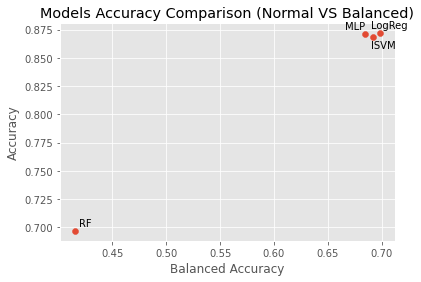

In [18]:
# Metrics to plot
x, y = p_test_balanced, p_test
x_label, y_label = "Balanced Accuracy", "Accuracy"

# Create scatter plot
plt.scatter(x, y)

# Add labels next to points
for label, x_, y_ in zip(model_names_in_plot, x, y):
    vert_alignment = (-10 if label == "MLP" else 10, -12 if label == "lSVM" else 5)
    plt.annotate(label, (x_, y_), textcoords="offset points", xytext=vert_alignment, ha='center')

# Add title and labels
plt.title('Models Accuracy Comparison (Normal VS Balanced)')
plt.xlabel(x_label)
plt.ylabel(y_label)

# Show plot
plt.show()

### Precision / Recall / F1 scores

In [23]:
from sklearn.metrics import f1_score, classification_report

for m in models_in_plot:
    print(model_names_sanitizer(m))
    print(classification_report(Y_test, pred[m]))
#[[n, f1_score(Y_test, p)] for n, p in predictions_models_test.items()]

LogReg
              precision    recall  f1-score   support

       Astro       0.97      0.99      0.98       156
        Endo       1.00      1.00      1.00        17
     L2/3 IT       0.86      0.98      0.91       271
          L4       0.87      0.90      0.88       217
       L5 IT       0.81      0.70      0.75        82
       L5 PT       0.92      0.98      0.95        57
       L6 CT       0.95      0.99      0.97       162
       L6 IT       0.84      0.72      0.77       144
         L6b       0.94      0.83      0.88        18
       Lamp5       0.94      0.58      0.71        52
  Macrophage       0.94      0.99      0.96        82
       Meis2       0.00      0.00      0.00        10
          NP       1.00      0.81      0.90        32
       Oligo       0.78      1.00      0.87       184
        Peri       0.43      0.75      0.55         4
       Pvalb       0.98      0.96      0.97        56
         SMC       0.00      0.00      0.00         2
        Sncg       0

/apps/gent/RHEL8/zen3x-ib/software/scikit-learn/1.0.1-foss-2021b/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/gent/RHEL8/zen3x-ib/software/scikit-learn/1.0.1-foss-2021b/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/gent/RHEL8/zen3x-ib/software/scikit-learn/1.0.1-foss-2021b/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi